# ARIMA 
ARIMA (Autoregressive Integral Moving Average) for forcasting based on past values of a time series to predict future values.
(https://www.youtube.com/watch?v=gqryqIlvEoM)

In [2]:
from IPython.core.debugger import set_trace

#%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [4]:
def read_Day_csv(hist_file):
    dfM = pd.read_csv(hist_file)
    dfM.columns=["Time","M1","M2","M3","state"]
    return dfM

In [8]:
#file
hist_file = "../Data/Historical logs/day_faulty_light.csv"           # one day run
df= read_Day_csv(hist_file)

In [9]:
df.head()

,Time,M1,M2,M3,state
0,0,0.962056,0.433821,0.953896,0
1,5,0.962056,0.433821,0.953896,0
2,10,0.962056,0.433821,0.953896,0
3,15,0.962056,0.433821,0.953896,0
4,20,0.962056,0.433821,0.953896,0


In [10]:
df = df[['M1']].copy()
df.head()

,M1
0,0.962056
1,0.962056
2,0.962056
3,0.962056
4,0.962056


In [11]:
df.describe()

,M1
count,3084.000000
mean,0.772907
std,0.160398
min,0.531832
25%,0.625551
50%,0.755924
75%,0.946324
max,0.973387


An ARIMA is characterised by three terms: p, d, and q.

- p is the order of AR (autoregressive) term
- d is the number of differencing rquired to make the time series stationary
- q is the order of the MA 

Any stationary time series can be modelled as with ARIMA models.

### Stationary
Substract the previous value from the current value. If we differenciate just once, we might not get an stationary series so multiple times may be required.

The number differenciating operations needed is an input of the ARIMA model.

#### ADF test

We can use the Augmented Dickey Fuller (ADF) test to check if the series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less that a significance level (sigma=0.05), the hypothesis can be rejected and infer that the time-series is non-stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(df.M1.dropna())
print(f"ADF Statistics: {results[0]}")
print(f"p-value: {results[1]}")

ADF Statistics: -0.1911563740566335
p-value: 0.939567577056307


As the value is 0.93, the time-series is non-sationary.


### Autocorrelation Function (ACF)

(Jump to pmdarima to easier get the number of diference)

In the following example we difference the function once and twice. This makes the series stationary around zero. To check how many times we must difference our time-series we can use ACF. This plot_acf helps visualise the autocorrelation --I need to double check if also the significance value as a shaded blue.
With one diffeerence, the significance value is already very low and the values oscilate around 0. Two difference did not make a huge difference.--

PS. Notice that double plots is an error of this python library...

Text(0.5, 1.0, 'Original')

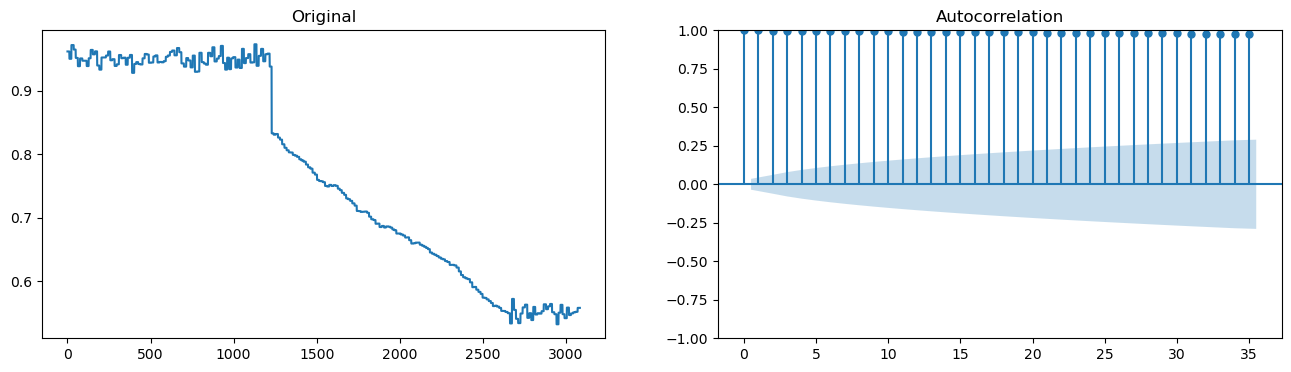

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df.M1)
plot_acf(df.M1, ax=ax2)
ax1.set_title("Original")

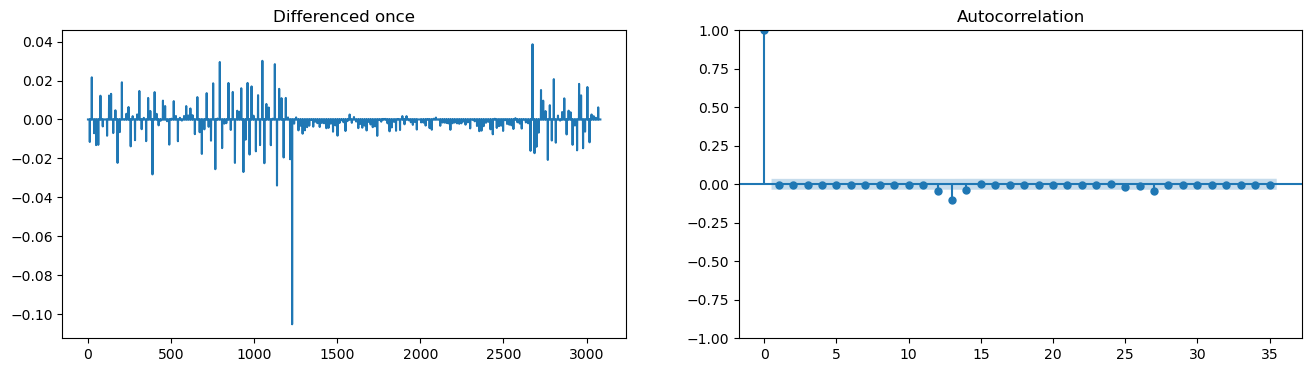

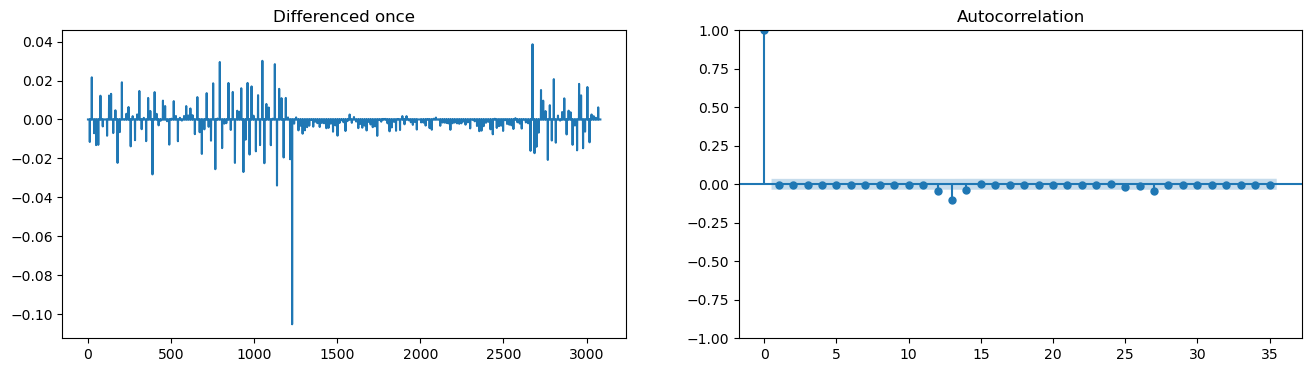

In [34]:
diff = df.M1.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Differenced once")
plot_acf(diff, ax=ax2)

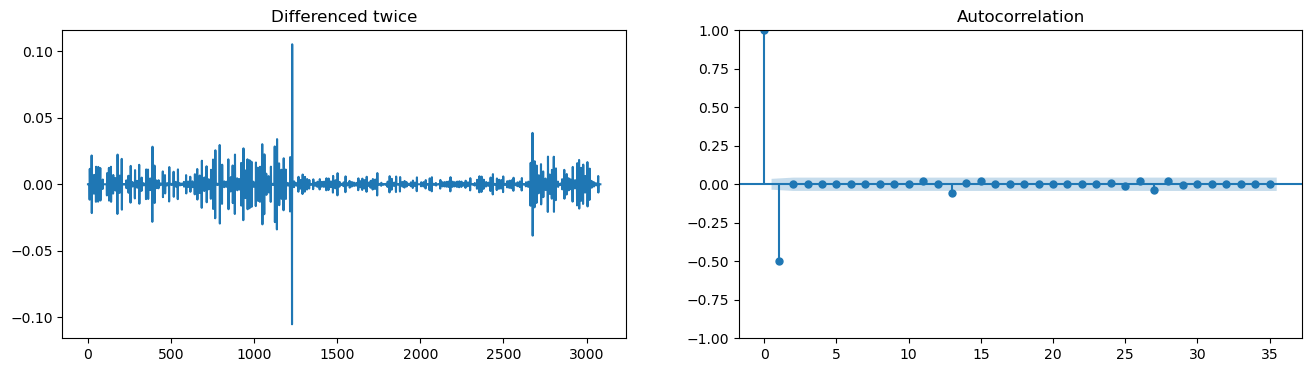

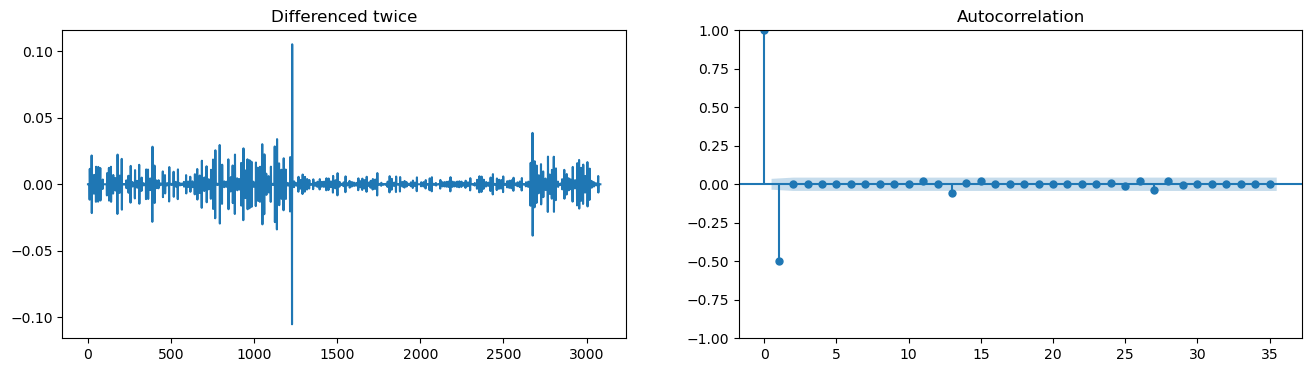

In [33]:
diff = df.M1.diff().diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Differenced twice")
plot_acf(diff, ax=ax2)

#### pndarima
... or simply use pndarima

In [36]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.M1,test="adf")

1

##### We can continue as suggested in (https://www.youtube.com/watch?v=gqryqIlvEoM) to get p and q parameters... surely there's some python package that automates these for you... and there is!

# ARIMA in python packages 

We can use similar packages for the p and q

In [37]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [39]:
arima_model = auto_arima(df['M1'], seasonal=False, trace=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-26364.790, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26372.786, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26370.793, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26370.793, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26370.083, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26368.793, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 9.625 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3084
Model:               SARIMAX(0, 1, 0)   Log Likelihood               13188.393
Date:                Sun, 31 Mar 2024   AIC                         -26372.786
Time:                        23:02:59   BIC                         -26360.718
Sample:                             0   HQIC                        -26368.45

In [41]:
# Get the ARIMA parameters
p, d, q = arima_model.order

# Fit ARIMA model
model = ARIMA(df['M1'], order=(p, d, q))
fitted_model = model.fit()


/Users/grisv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
# Forecast future values
forecast = fitted_model.forecast(steps=1000)  # Change 10 to the number of steps you want to forecast
print(forecast)

3084    0.557712
3085    0.557712
3086    0.557712
3087    0.557712
3088    0.557712
          ...   
4079    0.557712
4080    0.557712
4081    0.557712
4082    0.557712
4083    0.557712
Name: predicted_mean, Length: 1000, dtype: float64


In [56]:
type(forecast)
forecast.index

RangeIndex(start=3084, stop=4084, step=1)

In [57]:
s = pd.Series(forecast.values, index=forecast.index, name='M1')
dfPred = s.to_frame()
dfPred

,M1
3084,0.557712
3085,0.557712
3086,0.557712
3087,0.557712
3088,0.557712
...,...
4079,0.557712
4080,0.557712
4081,0.557712
4082,0.557712


In [58]:
#dfPred = pd.DataFrame(type(forecast))
#concatenated_df = pd.concat([df, dfPred], ignore_index=True)

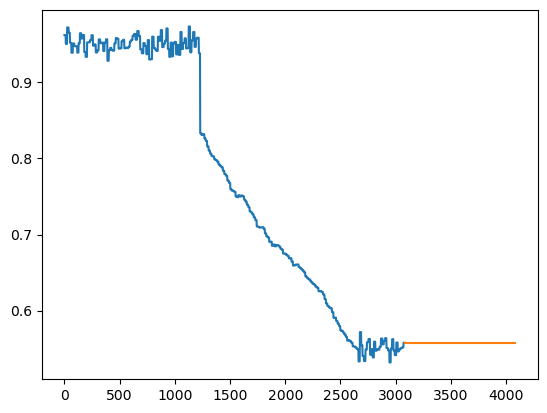

In [59]:
plt.plot(df.index,df.M1)
plt.plot(dfPred.index,forecast)